### YANGYANG DAI
### PS5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core import datetools
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import LeaveOneOut
import seaborn as sb
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  after removing the cwd from sys.path.
/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Q1

##### (a)

In [3]:
wine = pd.read_csv("strongdrink.txt")
wine = wine[['cultivar', 'alco', 'malic', 'tot_phen', 'color_int']]
wine.head()

,cultivar,alco,malic,tot_phen,color_int
0,1,14.23,1.71,2.80,5.64
1,1,13.20,1.78,2.65,4.38
2,1,13.16,2.36,2.80,5.68
3,1,14.37,1.95,3.85,7.80
4,1,13.24,2.59,2.80,4.32


In [4]:
X = wine[['alco', 'malic', 'tot_phen', 'color_int']]
y = wine[['cultivar']]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25, random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)
y_pred = MultLogReg.predict(X_test)

/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
pd.crosstab(index = y_test["cultivar"], columns = 'count')
print(classification_report(y_test, MultLogReg.predict(X_test)))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



we can see that category is best at predicting, and it has the fewest observations. Therefore the most accurately predicted category is not the one with the most observations.

In [6]:
print('Validation set MSE = ', mean_squared_error(y_test, y_pred))

Validation set MSE =  0.0454545454545


##### (b)

In [7]:
Xvals = X.values
yvals = y.values
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
N_loo = Xvals.shape[0]
MSE = pd.DataFrame({'index': np.zeros(N_loo), 
                    'error': np.zeros(N_loo), 
                    'y_pred': np.zeros(N_loo),
                    'y_test': np.zeros(N_loo)})
for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE['index'][test_index] = test_index
    MSE['error'][test_index] = (((y_test - y_pred) ** 2) != 0).astype(int)
    MSE['y_pred'][test_index] = y_pred
    MSE['y_test'][test_index] = y_test

/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
error_1 = MSE[MSE['y_pred'] == 1]['error'].mean()
error_2 = MSE[MSE['y_pred'] == 2]['error'].mean()
error_3 = MSE[MSE['y_pred'] == 3]['error'].mean()
General_MSE = MSE['error'].mean()
print(classification_report(MSE['y_test'], MSE['y_pred'], digits=3))
print('The error rate for class 1 is', error_1, ', std is', MSE[MSE['y_pred'] == 1]['error'].std())
print('The error rate for class 2 is', error_2, ', std is', MSE[MSE['y_pred'] == 2]['error'].std())
print('The error rate for class 3 is', error_3, ', std is', MSE[MSE['y_pred'] == 3]['error'].std())
print('The average MSE (for all classes) is', General_MSE,
      ', std is', MSE['error'].std())

             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176

The error rate for class 1 is 0.09836065573770492 , std is 0.3002730997379377
The error rate for class 2 is 0.08571428571428572 , std is 0.2819629507400967
The error rate for class 3 is 0.044444444444444446 , std is 0.20840907713999288
The average MSE (for all classes) is 0.07954545454545454 , std is 0.2713602101199873


Compared to part(a), the precision got worse. 

##### (c)

In [9]:
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(Xvals)

4

In [10]:
MSE_vec_kf = np.zeros(k)
ytests = np.array([])
ypreds = np.array([])
k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    print('k index=', k_ind)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    ytests = np.append(ytests, y_test)
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypreds = np.append(ypreds, y_pred)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 1.01239669421
k index= 1
MSE for test set 1  is 1.32334710744
k index= 2
MSE for test set 2  is 1.16115702479
k index= 3
MSE for test set 3  is 1.0867768595
test estimate MSE k-fold= 1.14591942149 test estimate MSE standard err= 0.115150911452


/Users/yangyangdai/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The precion is worse than part a and b.

In [11]:
print(classification_report(ytests, ypreds))
print (f'the error rates for j=1,2,3 are {1-0.81},{1-0.81},{1-0.96} respectively.')

             precision    recall  f1-score   support

        1.0       0.78      0.73      0.75        59
        2.0       0.79      0.85      0.82        71
        3.0       0.96      0.93      0.95        46

avg / total       0.83      0.83      0.83       176

the error rates for j=1,2,3 are 0.18999999999999995,0.18999999999999995,0.040000000000000036 respectively.


## Q2

In [43]:
cool = pd.read_csv('CoolIndex.txt', names = ['age', 'coolness'])

In [44]:
cool.head()

,age,coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


##### scatterplot

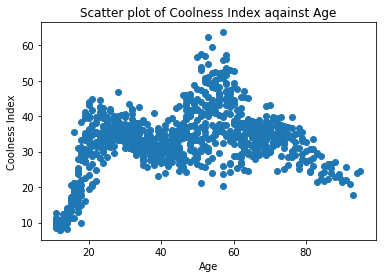

In [55]:
fig, ax = plt.subplots()
ax.scatter(cool['age'], cool['coolness'])
ax.set_xlabel("Age")
ax.set_ylabel("Coolness Index")
ax.set_title("Scatter plot of Coolness Index aqainst Age")
fig

#### Stepwise function

In [56]:
cutoff = np.array([21, 39, 58, 76])
cool.loc[:,"binnum"] = np.searchsorted(cutoff, cool.age)
cool = pd.concat((cool, 
    pd.get_dummies(cool.binnum, prefix = "bin")),
    axis = 1)
reg = sm.OLS(cool.coolness, cool.iloc[:,-5:]).fit()

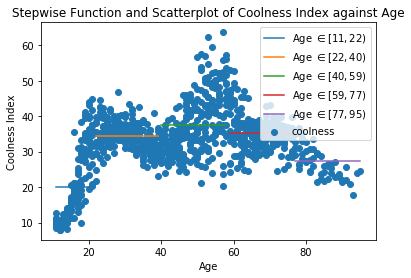

In [58]:
bins = [
    "$\in [11, 22)$",
    "$\in [22, 40)$",
    "$\in [40, 59)$",
    "$\in [59, 77)$",
    "$\in [77, 95)$"
]
for i in range(5):
    ax.plot(cool.loc[cool.binnum == i, "age"], np.ones((cool.binnum == i).sum()) * reg.params[i], 
            label = 'Age ' + bins[i])
ax.set_title("Stepwise Function and Scatterplot of Coolness Index against Age")
ax.legend()
fig

In [59]:
print("beta 0 to beta 5 are as follows:")
reg.params

beta 0 to beta 5 are as follows:


bin_0    20.102457
bin_1    34.475788
bin_2    37.635105
bin_3    35.225400
bin_4    27.296378
dtype: float64

In [60]:
print("Predicted coolness of a 73-year old is")
reg.params[np.searchsorted(cutoff, 73)]

Predicted coolness of a 73-year old is


35.225400040242754

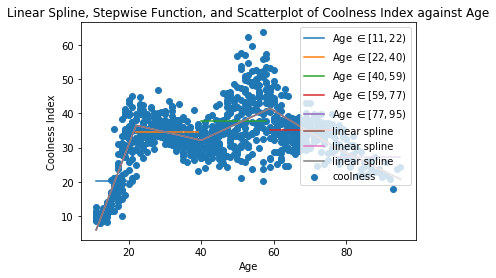

In [66]:
knots = [22, 40, 59, 77]
spl_c = LSQUnivariateSpline(cool.age.values, cool.coolness.values, knots, k=1)
age_vec = np.linspace(cool.age.values.min(), cool.age.values.max(), 1000)
ax.plot(age_vec, spl_ci(age_vec), label = "linear spline")
ax.legend()
ax.set_title("Linear Spline, Stepwise Function, and Scatterplot of Coolness Index against Age")
fig

In [67]:
print("Predicted coolness of a 73-year old from linear spline is")
spl_ci(73)

Predicted coolness of a 73-year old from linear spline is


array(32.536832389143306)

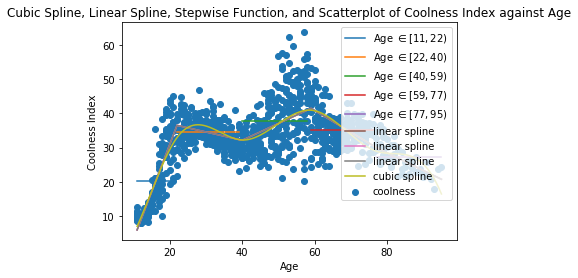

In [68]:
cubspl_ci = LSQUnivariateSpline(cool.age.values, cool.coolness.values, knots, k=3)
age_vec = np.linspace(cool.age.values.min(), cool.age.values.max(), 1000)
ax.plot(age_vec, cubspl_ci(age_vec), label = "cubic spline")
ax.legend()
ax.set_title("Cubic Spline, Linear Spline, Stepwise Function, and Scatterplot of Coolness Index against Age")
fig

In [69]:
print("Predicted coolness of a 73-year old from cubic spline is")
cubspl_ci(73)

Predicted coolness of a 73-year old from cubic spline is


array(31.262429389257864)